In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [44]:
class NeuralNetwork:
	def __init__(self, parameters: np.ndarray = np.zeros((13002, 1))) -> None:
		if parameters.shape != (13002, 1):
			raise ValueError('parameters shape should be (13002, 1)!')
		
		self.parameters = parameters

		count = 0
		
		# weights1 is of size (16)x(28*28)
		total_size = 16*28*28
		self.weights1 = parameters[count:count+total_size].reshape(16, 28*28)

		count += total_size 

		# biases1 is of size 16x1
		total_size = 16*1
		self.biases1 = parameters[count:count+total_size].reshape(16, 1)

		count += total_size 

		# weights2 is of size 16x16
		total_size = 16*16
		self.weights2 = parameters[count:count+total_size].reshape(16, 16)

		count += total_size 

		# biases2 is of size 16x1
		total_size = 16*1
		self.biases2 = parameters[count:count+total_size].reshape(16, 1)
		
		count += total_size 

		# weights3 is of size 10*16
		total_size = 10*16
		self.weights3 = parameters[count:count+total_size].reshape(10, 16)

		count += total_size 

		# biases3 is of size 10*1
		total_size = 10*1
		self.biases3 = parameters[count:count+total_size].reshape(10, 1)

		self.input_layer = np.zeros((784, 1))
		
		# inner hidden layers of the network
		self.z_hlayer1 = np.zeros((16, 1))
		self.hlayer1 = NeuralNetwork.sigmoid(self.z_hlayer1)

		self.z_hlayer2 = np.zeros((16, 1))
		self.hlayer2 = NeuralNetwork.sigmoid(self.z_hlayer2)

		self.z_output_layer = np.zeros((10, 1))
		self.output_layer = NeuralNetwork.sigmoid(self.z_output_layer)

		del total_size
		del count


	def load_input_layer(self, input_vector: np.ndarray) -> None:
		"""
			Laad the input handwritten digit
			input_vector: np.ndarray of shape (784, 1)
			these numbers are between 0-255
			the function will squish them between 0-1
		"""
		self.input_layer = (input_vector / 255)
		

	def cost_of_single_sample(self, sample: np.ndarray, true_label: int) -> float:
		self.load_input_layer(input_vector=sample)
		self.feed_forward()
		
		# construct the output vector based on the label
		desired_output = np.zeros((10, 1))
		desired_output[true_label] = 1.0
		
		# compare the self.output_layer and the desired_output
		# using mean squared error
		cost = np.sum((self.output_layer - desired_output)**2)
		return cost
	

	def cost_of_test_data(self, test_samples: np.ndarray, true_labels: np.ndarray) -> float:
		"""
			samples.shape = (784, m)
			true_labels.shape = (1, m)
			samples: is a np array which each col represents one sample, and 
			each col has 784 numbers in them, the pixel values
			
		"""

		MSE: float = 0
		for sample, label in zip(test_samples.T, true_labels[0]):
			MSE += self.cost_of_single_sample(sample, label)
		
		M = len(test_samples.T)
		MSE = (1 / M) * MSE
		return MSE
	

	def accuracy_score(self, test_samples: np.ndarray, true_labels: np.ndarray) -> float:
		#* test_samples.shape = (784, m)
		#* true_labels.shape = (1, m)

		total: int = len(test_samples.T)
		trues: int = 0

		for sample, label in zip(test_samples.T, true_labels[0]):
			result = self.predict(sample)
			if result == label:
				trues += 1
		
		return (trues / total)


	def predict_v(self, sample: np.ndarray) -> np.ndarray:
		#* sample.shape = (784, 1)
		self.load_input_layer(input_vector=sample)
		self.feed_forward()
		
		return self.output_layer

	
	def predict(self, sample) -> int:
		output_vector = self.predict_v(sample)
		return np.argmax(output_vector)


	def backprop_one_sample(self, sample: np.ndarray, label: int) -> tuple:
		"""
			This method holds all the math and calculus behind backpropagation
			it calculates the derivitive of the cost w.r.t all the weights and
			biases of the network, for only one training data
		"""
		
		self.load_input_layer(input_vector=sample)
		self.feed_forward()

		#* convert the label in int format into a one-hot vector
		desired_output = np.zeros(self.output_layer.shape)
		desired_output[label] = 1.0
		
		#* d_cost_p_ol.shape = (10, 1)
		d_cost_p_ol = 2 * (self.output_layer - desired_output)

		#* d_sigmoid(z_ol)
		#* times the gradient of the cost w.r.t activations of the output layer
		#* error_ol.shape = (10, 1)
		error_ol = NeuralNetwork.d_sigmoid(self.z_output_layer) *  d_cost_p_ol

		#* d_sigmoid(self.z_hlayer2).shape = (16, 1)
		#* self.weights3.T.shape = (10, 16).T -> (16, 10)
		#* error_ol.shape = (10, 1)
		#* error_hl2.shape = (16, 1)
		error_hl2 = NeuralNetwork.d_sigmoid(self.z_hlayer2) * (self.weights3.T @ error_ol)


		#* d_sigmoid(self.z_hlayer1).shape = (16, 1)
		#* self.weights2.T.shape = (16, 16).T -> (16, 16)
		#* error_hl2.shape = (16, 1)
		#* error_hl1.shape = (16, 1)
		error_hl1 = NeuralNetwork.d_sigmoid(self.z_hlayer1) * (self.weights2.T @ error_hl2)
		
		#* d_cost_p_b3.shape = output_layer.shape = (10, 1)
		d_cost_p_b3 = error_ol
	

		#* d_cost_p_b2.shape = hlayer2.shape = (16, 1)
		d_cost_p_b2 = error_hl2


		#* d_cost_p_b1.shape = hlayer1.shape = (16, 1)
		d_cost_p_b1 = error_hl1

		#* the derivative of the cost wr to the weights of the layer l will be
		#* the matrix mult of error of layer l and activation of layer l-1 transposed
		
		#* error_ol.shape = (10, 1)
		#* self.hlayer2.T.shape = (16, 1).T = (1, 16)
		#* d_cost_p_w3.shape = (10, 16)
		d_cost_p_w3 = (error_ol @ self.hlayer2.T)
		

		#* error_hl2.shape = (16, 1)
		#* self.hlayer1.T.shape = (16, 1).T = (1, 16)
		#* d_cost_p_w2.shape = (16, 16)
		d_cost_p_w2 = (error_hl2 @ self.hlayer1.T)
		
		
		#* error_hl1.shape = (16, 1)
		#* self.input_layer.T.shape = (784, 1).T = (1, 784)
		#* d_cost_p_w1.shape = (16, 784)
		d_cost_p_w1 = (error_hl1 @ self.input_layer.T)


		return (
			d_cost_p_w1,
			d_cost_p_b1,
			d_cost_p_w2,
			d_cost_p_b2,
			d_cost_p_w3,
			d_cost_p_b3
		)

	
	def backpropagation(self, x_train: np.ndarray, y_train: np.ndarray) -> tuple:
		"""
			This method will run the backprop_one_sample method for a dataset and 
			take the average of all the gradients of the weights and biases
		"""

		#* m training samples
		#* x_train.shape = (784, m)
		#* y_train.shape = (1, m)
		
		
		dw1 = np.zeros(self.weights1.shape)
		db1 = np.zeros(self.biases1.shape)
		
		dw2 = np.zeros(self.weights2.shape)
		db2 = np.zeros(self.biases2.shape)
		
		dw3 = np.zeros(self.weights3.shape)
		db3 = np.zeros(self.biases3.shape)

		
		for features, label in zip(x_train.T, y_train[0]):
			#* label: int
			#* features.shape = (784, 1)
			
				
			#* label in this method should be an int
			(
				tdw1, 
				tdb1, 
				tdw2, 
				tdb2, 
				tdw3, 
				tdb3
			) = self.backprop_one_sample(sample=features, label=label)
			
			dw1 += tdw1
			db1 += tdb1
			dw2 += tdw2
			db2 += tdb2
			dw3 += tdw3
			db3 += tdb3

		#* now the dw1, db1, dw2, db2, dw3, db3 contain the sum of the derivatives of 
		#* the samples inside the training data
		#* now they should be divided by the number of the train sample size, so dw and db, be an average
		train_data_size = x_train.shape[1]
		
		dw1 /= train_data_size
		db1 /= train_data_size
		dw2 /= train_data_size
		db2 /= train_data_size
		dw3 /= train_data_size
		db3 /= train_data_size
		
		#* now they contain the gradient of the provided dataset
		return (
			dw1,
			db1,
			dw2,
			db2,
			dw3,
			db3
		)
			

	def update_parameters(self, dw1, db1, dw2, db2, dw3, db3, learning_rate) -> None:
		self.weights1 -= learning_rate * dw1
		self.biases1 -= learning_rate * db1
		
		self.weights2 -= learning_rate * dw2
		self.biases2 -= learning_rate * db2

		self.weights3 -= learning_rate * dw3
		self.biases3 -= learning_rate * db3


	def train(
			self, 
			x_train: np.ndarray, 
			y_train: np.ndarray,
			*,
			learning_rate: float = 0.1,
			constant_lr: bool = False,
			number_of_epochs: int = 80,
			mini_batches_size: int = 100
	) -> None:
		"""Trains the model with the labeled training data"""

		#* initialize the parameters randomly
		#self.parameters = np.random.normal(size=(13002, 1))
		
		#* m training samples
		#* x_train.shape = (784, m)
		#* y_train.shape = (1, m)
		
		#* first we'd better attach the x_train and y_train together
		#* then we can shuffle the training data
		#* and then seperate the x and y again
		#* add y row to the 0-th row of train_data
		train_data = np.vstack((y_train, x_train))

		#! now because shuffle, shuffles the array based on the rows
		#! but we need to shuffle the data based on the coloumns
		#! we have to transpose it twice to get around this
		train_data = train_data.T
		np.random.shuffle(train_data)
		train_data = train_data.T

		#* now that the data is shuffled properly
		#* we should divide the data into mini-batches
		mini_batches: list[np.ndarray] = []
		count: int = 0
		while True:
			if count >= len(train_data.T):
				break
			
			mini_batches.append(train_data[:, count:count+mini_batches_size])
			count += mini_batches_size

		#* keep track of the accuracy scores, to plot later	
		scores: list[float] = []

		initial_lr: float = learning_rate
		decay_rate: float = 0.1
		for epoch in range(number_of_epochs):
			#* now each mini-batch corresponds to one step at gradient descent
			#* batch.shape = (784+1, mini_batches_size), the label and the features
			for batch in mini_batches:
				#* batch.shape = (785, mini_batches_size)
				x_train_batch = batch[1:] # (784, mini_batches_size)
				y_train_batch = batch[0:1] # (1, mini_batches_size)
				
				#* the backprop algorithm will run for each batch, one step downhill towards a local minima
				#* it also updates the self.output_layer and consequently the cost by running self.feed_forward
				dw1, db1, dw2, db2, dw3, db3 = self.backpropagation(x_train_batch, y_train_batch)

				if constant_lr:
					lr = learning_rate
				else:
					lr = np.exp(-epoch * decay_rate) * initial_lr


				#* change each of the weights and biases accordingly
				self.update_parameters(dw1, db1, dw2, db2, dw3, db3, learning_rate=lr)
			score = self.accuracy_score(x_train, y_train)*100				
			scores.append(score)
			print(f'epoch {epoch+1}: {score:.2f}%')

		self.plot_scores(list(range(1, number_of_epochs+1)), scores)

		
	def plot_scores(self, epochs_range: list[int], scores: list[float]) -> None:
		fig = plt.figure()
		fig.tight_layout()
		plt.title('Perfecting Accuracy Score')
		plt.xlabel('Epoch')
		plt.ylabel('Accuracy Score')
		plt.xticks(epochs_range)
		plt.plot(epochs_range, scores)
		plt.show()
				
	@staticmethod
	def sigmoid(x: np.ndarray) -> np.ndarray:
		return 1 / (1 + np.exp(-x))

	@staticmethod
	def d_sigmoid(x: np.ndarray) -> np.ndarray:
		return np.exp(-x) / (np.pow((1 + np.exp(-x)), 2))

	@staticmethod
	def softmax(x: np.ndarray) -> np.ndarray:
		return np.exp(-x) / np.sum(np.exp(-x))

	def feed_forward(self) -> None:
		"""
			Will calculate all the values in all the layers 
			based on the weights and biases 
		"""
		# hidden layer 1 has 16 neurons -> shape: (16, 1)
		# weights1.shape = (16, 784)
		# 16*784	784*1 + 16,1
		self.input_layer = self.input_layer.reshape((784, 1))

		self.z_hlayer1 = self.weights1 @ self.input_layer + self.biases1
		self.hlayer1 = NeuralNetwork.sigmoid(self.z_hlayer1)

		# hidden layer 2 has 16 neurons -> shape: (16, 1)
		self.z_hlayer2 = self.weights2 @ self.hlayer1 + self.biases2
		self.hlayer2 = NeuralNetwork.sigmoid(self.z_hlayer2)
		
		# output layer has 10 neurons -> shape(10, 1)
		# one neuron for each digit
		self.z_output_layer = self.weights3 @ self.hlayer2 + self.biases3
		self.output_layer = NeuralNetwork.sigmoid(self.z_output_layer)


		if self.output_layer.shape != (10, 1):
			raise ValueError(f'{self.output_layer.shape} not a correct shape!')


	def print_network(self, hidden_layers = False) -> None:
		if hidden_layers:
			print('hLayer 1:')
			print(self.hlayer1)
			
			print('hLayer 2:')
			print(self.hlayer2)

		print('Output Layer:')
		print(self.output_layer)


	def plot_network(self):
		layers = [
			self.hlayer1.reshape((16,)),
			self.hlayer2.reshape((16,)),
			self.output_layer.reshape((10,))		
		]

		fig, ax = plt.subplots()
		
		# Determine the positions for the layers
		layer_sizes = [len(layer) for layer in layers]
		v_spacing = max(layer_sizes) + 1 + 3  # Vertical spacing between neurons
		h_spacing = 15  # Horizontal spacing between layers
		
		# Iterate over layers
		for i, layer in enumerate(layers):
			y_pos = np.linspace(v_spacing / 2, -v_spacing / 2, len(layer))
			x_pos = np.full_like(y_pos, i * h_spacing)
			
			# Plot neurons
			for j, neuron_value in enumerate(layer):
				circle = plt.Circle((x_pos[j], y_pos[j]), radius=0.4, facecolor=str(neuron_value), edgecolor='k')
				ax.add_artist(circle)
				# Optional: Add text to show the neuron value
				ax.text(x_pos[j]+1.5, y_pos[j], f'{neuron_value:.2f}', ha='center', va='center', color='black')

			# Draw connections (optional)
			if i > 0:
				prev_layer = layers[i - 1]
				prev_y_pos = np.linspace(v_spacing / 2, -v_spacing / 2, len(prev_layer))
				prev_x_pos = np.full_like(prev_y_pos, (i - 1) * h_spacing)
				for k in range(len(prev_layer)):
					for l in range(len(layer)):
						ax.plot([prev_x_pos[k], x_pos[l]], [prev_y_pos[k], y_pos[l]], 'k-', lw=0.04)

		ax.set_aspect('equal')
		ax.axis('off')
		plt.tight_layout()
		plt.show()


	def show_sample(self, sample: np.ndarray):
		#* sample.shape = (784, 1)
		matrix = np.array(sample).reshape(28, 28)

		plt.imshow(matrix, cmap='gray', vmin=0, vmax=255)
		plt.axis('off')
		plt.show()

	
	def print_stat(self, x_test: np.ndarray, y_test: np.ndarray) -> None:
		score = self.accuracy_score(x_test, y_test)
		cost = self.cost_of_test_data(x_test, y_test)

		print(f'Accuracy = {score * 100:.2f}%')
		print(f'Cost = {cost:.3f}')

In [2]:
train_df = pd.read_csv('./data/mnist_train.csv')
test_df = pd.read_csv('./data/mnist_test.csv')

x_train = np.array(train_df.iloc[:, 1:]).transpose() # shape = 784 * m, so each col is a sample
y_train = np.array(train_df.iloc[:, 0:1]).reshape((1, -1)) # shape = 1 * m

x_test = np.array(test_df.iloc[:, 1:]).transpose()
y_test = np.array(test_df.iloc[:, 0:1]).reshape((1, -1))

In [65]:
ps = np.random.normal(size=(13002, 1))
NN = NeuralNetwork(parameters=ps)

In [66]:
NN.print_stat(x_test, y_test)

Accuracy = 13.03%
Cost = 4.665


epoch 1: 72.63%
epoch 2: 83.02%
epoch 3: 86.22%
epoch 4: 87.66%
epoch 5: 88.59%
epoch 6: 89.25%
epoch 7: 89.76%
epoch 8: 90.15%
epoch 9: 90.49%
epoch 10: 90.77%
epoch 11: 91.01%
epoch 12: 91.19%
epoch 13: 91.36%
epoch 14: 91.49%
epoch 15: 91.62%


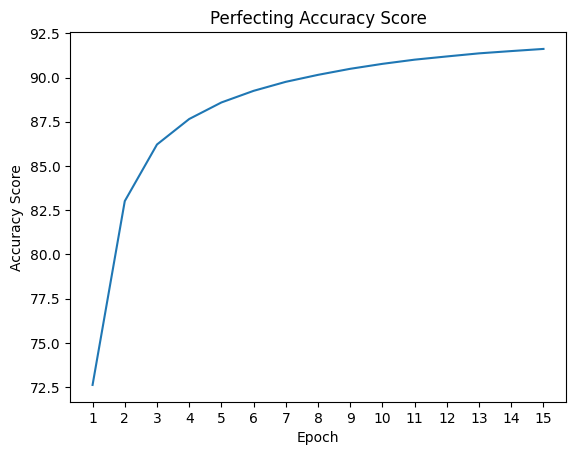

In [67]:
NN.train(x_train, y_train, number_of_epochs=15, mini_batches_size=120, learning_rate=1.7, constant_lr=False)

In [68]:
NN.print_stat(x_train, y_train)
NN.print_stat(x_test, y_test)

Accuracy = 91.62%
Cost = 0.133
Accuracy = 91.01%
Cost = 0.142


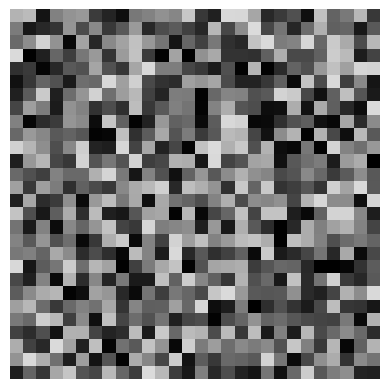

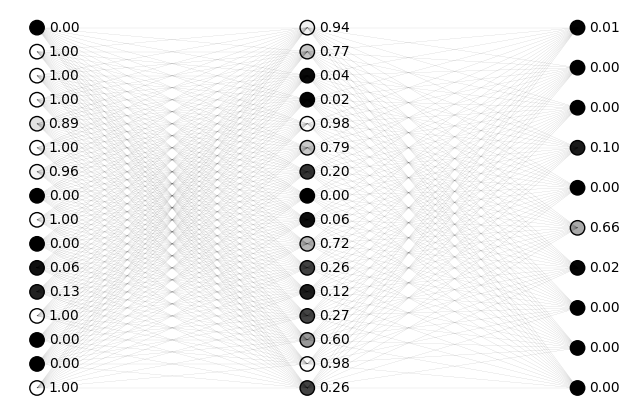

In [81]:
noise = np.random.randint(0, 220, size=(784, 1))
NN.show_sample(noise)
NN.load_input_layer(noise)
NN.feed_forward()
NN.plot_network()

In [60]:
custom_df = pd.read_csv('./custom_data.csv')
custom_test_x = np.array(custom_df).T
custom_test_x.shape

(784, 10)

0
[[5.01813499e-01]
 [1.75941639e-04]
 [2.56155429e-03]
 [6.85001861e-05]
 [6.48456470e-03]
 [2.49161506e-03]
 [2.29353669e-01]
 [8.33111000e-03]
 [2.13082154e-04]
 [1.87772699e-06]]


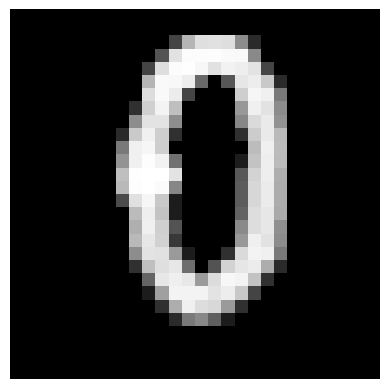

1
[[6.58604640e-06]
 [9.80910785e-01]
 [1.79824807e-03]
 [7.55463916e-03]
 [1.57074098e-03]
 [3.72617800e-03]
 [7.51210834e-03]
 [7.59362653e-03]
 [1.70768666e-03]
 [5.62755452e-04]]


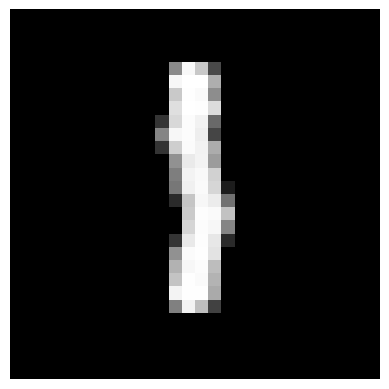

2
[[5.65203238e-04]
 [5.49126064e-03]
 [9.67180610e-01]
 [4.47278247e-03]
 [2.48055620e-04]
 [2.87311415e-03]
 [5.79999412e-03]
 [1.86032797e-03]
 [1.16569740e-02]
 [6.18282037e-04]]


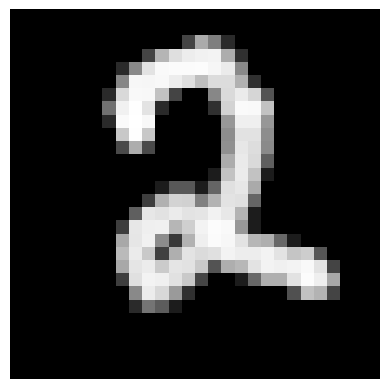

3
[[2.88514271e-04]
 [1.48982986e-02]
 [1.06591073e-01]
 [6.61955967e-01]
 [2.26212379e-03]
 [1.11865511e-03]
 [2.62107520e-04]
 [1.05913740e-02]
 [1.73295024e-02]
 [6.67459999e-04]]


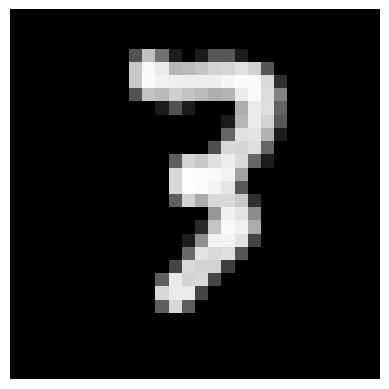

9
[[1.06411100e-04]
 [8.29074958e-04]
 [2.84614110e-05]
 [1.34020923e-03]
 [4.32100726e-02]
 [6.77597980e-02]
 [4.23654113e-04]
 [8.19559744e-03]
 [7.06970455e-03]
 [9.24401238e-01]]


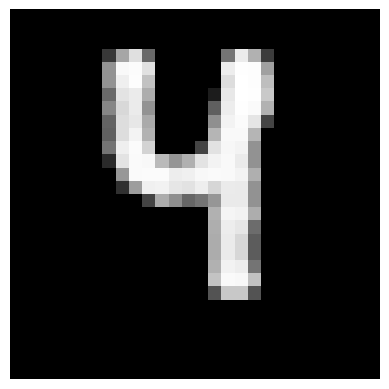

5
[[1.39201623e-02]
 [9.27337499e-04]
 [2.98110491e-04]
 [1.08632749e-01]
 [1.26078576e-04]
 [8.49155383e-01]
 [1.20396259e-01]
 [6.02456136e-04]
 [2.37724043e-04]
 [3.97733789e-06]]


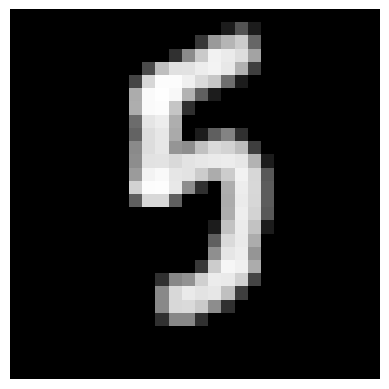

8
[[1.98791306e-02]
 [5.44994354e-03]
 [2.02077955e-04]
 [2.09883470e-04]
 [1.55113479e-03]
 [1.20700038e-01]
 [1.42797085e-01]
 [5.10425095e-04]
 [6.77453559e-01]
 [6.40955875e-02]]


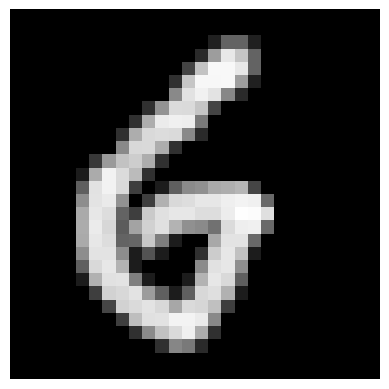

7
[[1.50670102e-02]
 [6.19648732e-05]
 [1.80679518e-02]
 [2.18570605e-01]
 [2.18474340e-04]
 [3.49822899e-03]
 [4.71659875e-06]
 [3.80138269e-01]
 [3.21706851e-05]
 [8.31951897e-05]]


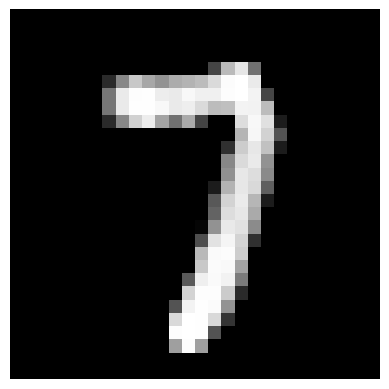

2
[[2.19788831e-03]
 [1.87173974e-02]
 [5.62399375e-01]
 [3.24567278e-04]
 [8.77066806e-05]
 [1.07642366e-01]
 [2.06356710e-01]
 [4.82546672e-04]
 [5.36866297e-02]
 [5.99526935e-04]]


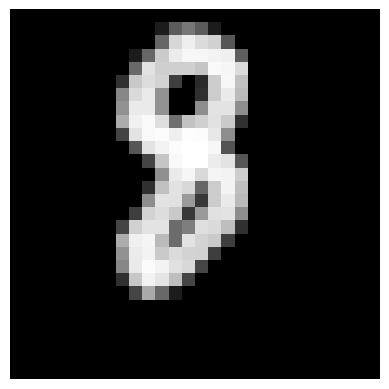

8
[[3.04162831e-03]
 [1.05363975e-02]
 [1.89480663e-01]
 [7.53952158e-03]
 [1.21163641e-04]
 [1.48712816e-01]
 [4.35956233e-03]
 [2.59187961e-03]
 [2.66347537e-01]
 [3.75711809e-04]]


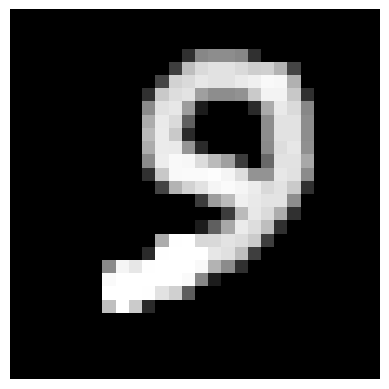

0.6

In [72]:
for sample in custom_test_x.T:
	print(NN.predict(sample))
	print(NN.predict_v(sample))
	NN.show_sample(sample)

NN.accuracy_score(custom_test_x, [list(range(10))])

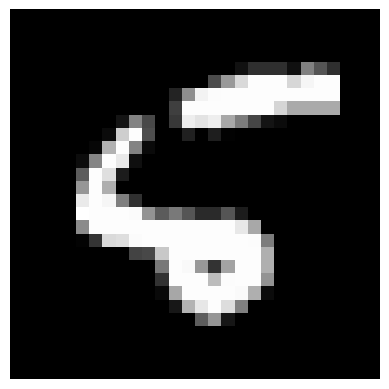

true label: 5
prediction: 6


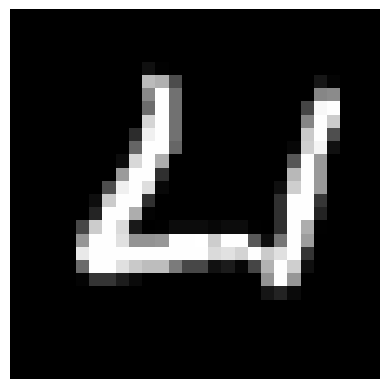

true label: 4
prediction: 5


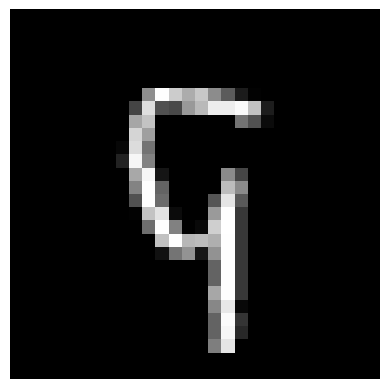

true label: 9
prediction: 4


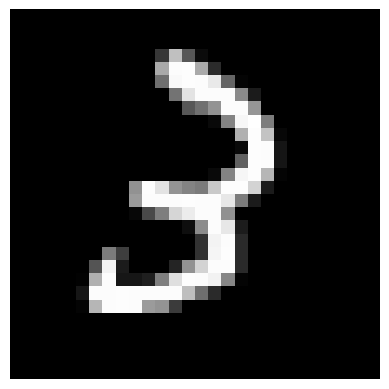

true label: 3
prediction: 2


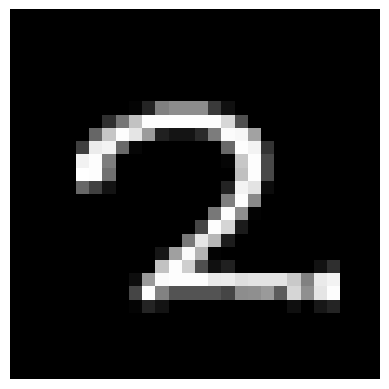

true label: 2
prediction: 7


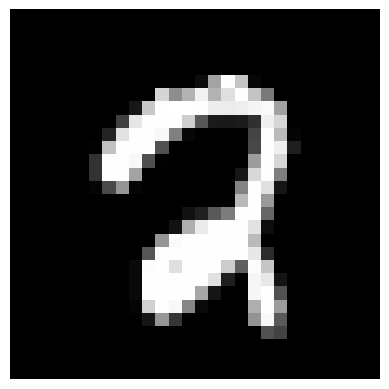

true label: 2
prediction: 7


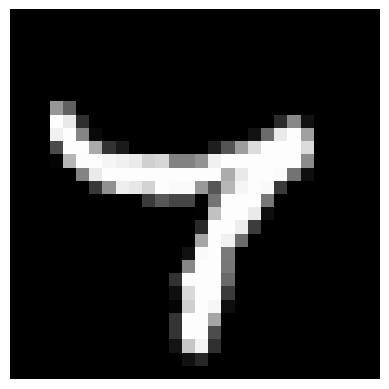

true label: 7
prediction: 4


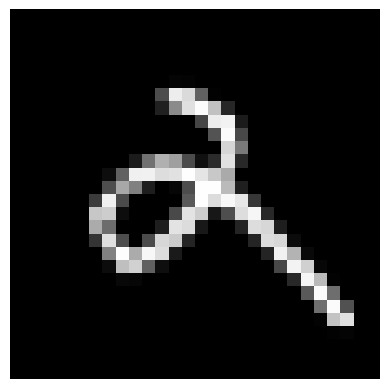

true label: 2
prediction: 4


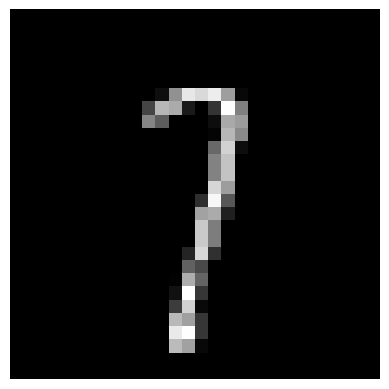

true label: 7
prediction: 3


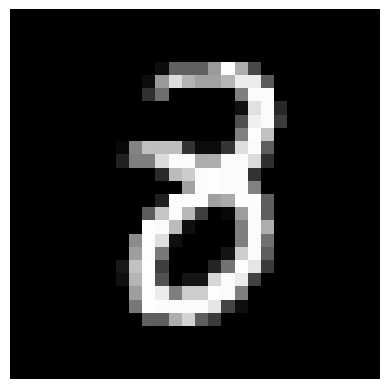

true label: 8
prediction: 2


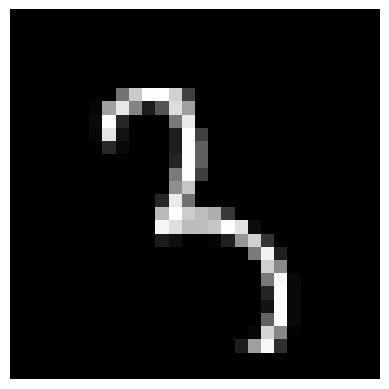

true label: 3
prediction: 8


In [90]:
#* examples where the prediction was not correct
for i, (sample, label) in enumerate(zip(x_test.T, y_test[0])):
	p = NN.predict(sample)
	if p != label:
		NN.show_sample(sample)
		print(f'true label: {label}')
		print(f'prediction: {p}')
	if i >= 200: break	

layers = [NN.hlayer1.reshape((16,)), NN.hlayer2.reshape((16,)), NN.output_layer.reshape((10,))]
#plot_neural_network(layers)